In [1]:
import math

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline
sns.set_style('white')

## Test Statistics

There are two main aspects of a regression model that can be evaluated using significance tests: 1) Whether the model, as a whole, explains more variance in the outcome than a model with no features, and 2) Whether each individual feature in the model adds additional explanatory power.

### Whole model: F-test
The whole-model test of explanatory power is an F-test.  The F-test can be calculated in different ways depending on the situation, but principally represents the ratio between the unexplained variance of your model and the unexplained variance of a reduced model to which our model is compared.  Here, the "reduced model" is a model with no features, meaning all variance in the outcome is unexplained.  For a linear regression model with two parameters $y=\alpha+\beta x$, the F-test is built from these pieces:

* unexplained model variance:

$$SSE_F=\sum(y_i-\hat{y}_i)^2$$

* unexplained variance in reduced model:

$$SSE_R=Var_y = \sum(y_i-\bar{y})^2$$

 * number of parameters in the model:

$$p_F = 2 (\alpha \text{ and } \beta)$$

 * number of parameters in the reduced model:

$$p_R = 1 (\alpha)$$

 * number of datapoints:

$$n$$

 * degrees of freedom of $SSE_F$:

$$df_F = n - p_F$$

 * degrees of freedom of $SSE_R$:

$$df_R = n - p_R$$

These pieces come together to give us the full equation for the F-test:

$$F=\dfrac{SSE_F-SSE_R}{df_F-df_R}÷\dfrac{SSE_F}{df_F}$$

This introduces some new terminology.  A **parameter** is any predictor in a regression model, including both the intercept and the features.   **Degrees of freedom** quantify the amount of information "left over" to estimate variability after all parameters are estimated.

In regression, degrees of freedom for a function works like this:  With two datapoints, a regression line $y=\alpha + \beta x$ has 0 degrees of freedom (2 minus the number of parameters).  Those two parameters encompass all the information in the data.  Knowing $\alpha$ and $\beta$ alone, we can perfectly reproduce the original data.  No additional information is available from the data itself.

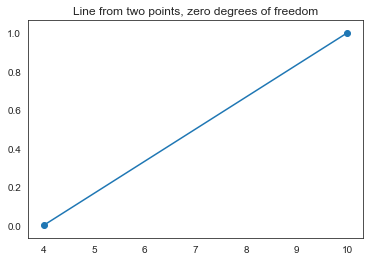

In [2]:
y = [0, 1]
x = [4, 10]
plt.scatter(x, y)
plt.plot(x, y)
plt.title("Line from two points, zero degrees of freedom")
plt.show()

If we add another datapoint and fit a new model with the same number of parameters, we have 1 degree of freedom.  In order to perfectly reproduce the data, we would need to know $\alpha$, $\beta$, *and* the value of one of the datapoints.  That means we have one point of free information not captured by the model.

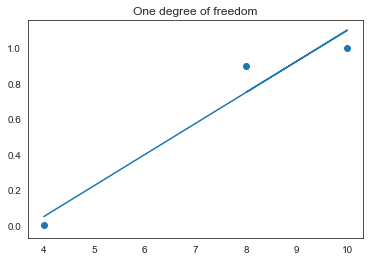

In [3]:
y=[0, 1, .9]
x=[4, 10, 8]
plt.scatter(x, y)
plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x))
plt.title("One degree of freedom")
plt.show()

Low degrees of freedom are a warning indicator- either of overfitting, or of a very small sample.  If you want to learn more and really like math, a very thorough discussion of degrees of freedom can be found [here on StackExchange](http://stats.stackexchange.com/questions/16921/how-to-understand-degrees-of-freedom).

An F-test has two degree of freedom indicators: The degrees of freedom of the model ($p-1$), and the degrees of freedom of $SSE_F$ ($n-p_F$).  These degrees of freedom define the F-distribution for that F-test value.  Just like with a t-test and a t-distribution, the location of the F-test value within the F-distribution is used to determine the p-value – the probability of getting an F-test of that value or higher if there were no relationship between the outcome and the parameters in the population.  A significant (usually $\alpha < .05$) p-value suggests that the model as a whole can explain some of the variance in the outcome.

Another way to think of the F-test is that it tests whether the $R^2$ of the model is different from zero. A non-significant F-test is a sign that your model is unable to predict the outcome and you need to make a new one.


### Individual parameters: t-test

Once you have a significant F-test, the next step in evaluating a model is to learn more about the performance of the individual parameters, particularly the features you introduced.  Each of the parameters in a model has its own statistical test, a t-test, that determines whether that parameter estimate is significantly different from zero, and therefore explains a statistically-significant amount of *unique* variance in the outcome, *after controlling for the variance explained by the other parameters*.  

![PCA pic](assets/pca_pic.png)

For instance, in a linear regression with the yellow circle as the outcome, the total variance explained by the model is represented by all the area of the yellow outcome circle that overlaps with the blue and pink feature circles.  However, the statistical test of the significance of the blue circle will be done on *only* the green area where blue and yellow overlap, ignoring the area of shared overlap among blue, pink, and yellow.   Similarly, the statistical test of the significance of the pink circle will be done on *only* the orange area where the pink and yellow overlap.

A significant F-test does not guarantee that all the parameters in a model will be significant!  In fact, under circumstances of high multicollinearity (such as Set A), it is possible to get a significant F-test without any statistically significant features at all.

A non-significant parameter does not contribute new information about the outcome variable, and can be discarded with little to no decrease in the model's explanatory power as quantified by $R^2$.

Let's see this in action:

The `LinearRegression` function from `scikit-learn` can be used for multivariate linear regression as well as single linear regression.  However, because `scikit-learn` as a package is focused on machine learning prediction rather than statistical interpretation, it is difficult to extract p-values for individual parameters. You have to write additional code to calculate them.  

However, there are other machine learning packages and now is a great time to introduce one of them, `statsmodels`. This package is the primary alternative to `scikit-learn`, offering many of the same models with slightly different syntax and formatting. It is useful to be familiar with because on occasion something that takes additional steps or work in one package is easily accessible in the other. P-values in linear regression is one such example. This information is easily returned in the `statsmodels` `ols` function. It also has a rather nice interface where the model formula can be written out in a way that more closely resembled the functional form. Those of you familiar with R may recognize this as the way this kind of specification is done there.

Let's look at an example.


In [4]:
# Read data into a DataFrame.
data_url = 'https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv'
data = pd.read_csv(data_url, index_col=0)
data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [5]:
# Write out the model formula.
# Your dependent variable on the right, independent variables on the left
# Use a ~ to represent an '=' from the functional form
linear_formula = 'Sales ~ TV+Radio+Newspaper'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=data).fit()

Let's look at the coefficients of our model.

In [6]:
lm.params

Intercept    2.938889
TV           0.045765
Radio        0.188530
Newspaper   -0.001037
dtype: float64

And at the p-values as a significance test for each of the coefficients.

In [7]:
lm.pvalues

Intercept    1.267295e-17
TV           1.509960e-81
Radio        1.505339e-54
Newspaper    8.599151e-01
dtype: float64

Finally, here's our $R^2$:

In [8]:
lm.rsquared

0.8972106381789522

From the p-values, we see the p-value for Newspaper is greater than .05, suggesting that there is probably no effect for that feature – and that dropping it would not adversely affect the $R^2$.

### Drill: dropping features and re-fitting

Since the p-value for Newspaper indicates that it probably has no effect, try re-fitting the model without the Newspaper feature.  How much does the R^2 change?  Do the other parameters change?

In [9]:
# Re-fit the model here.
linear_formula = 'Sales ~ TV+Radio'

lm = smf.ols(formula=linear_formula, data=data).fit()

In [10]:
lm.params

Intercept    2.921100
TV           0.045755
Radio        0.187994
dtype: float64

In [11]:
lm.pvalues

Intercept    4.565557e-19
TV           5.436980e-82
Radio        9.776972e-59
dtype: float64

In [12]:
lm.rsquared

0.8971942610828956

As expected, dropping newspaper does not adversely affect R squared, as it's still at 0.897.
Now, all p-values are significant.

## Confidence intervals

Not only do we get parameter estimates and p-values, we also get error estimates that give us **confidence intervals**, the range of values within which our population parameter is likely to fall.  A 95% confidence interval is the default value in most software packages – it indicates that if we re-sampled the population over and over again, 95% of the time our estimates for that parameter would fall within that interval.  That information, in turn, can be used to estimate the confidence interval for our predicted value so that we not only know what value we expect, but with what level of certainty we can expect it.

In [13]:
lm.conf_int()

,0,1
Intercept,2.340343,3.501857
TV,0.043013,0.048497
Radio,0.172139,0.203850


Column '0' is the lower bound of the 95% confidence interval and column '1' is the upper bound.  A confidence interval that contains 0 is a sign that the parameter is not explaining significant variance in the outcome.  The wider the confidence intervals are, the more uncertainty there is about the model estimates.  

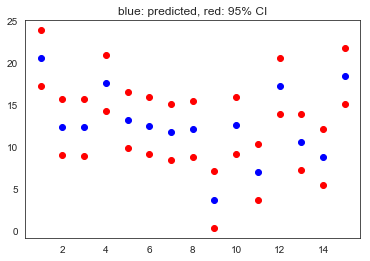

In [14]:
# Use wls_prediction_std to build confidence intervals and/or calculate standard deviation
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u[0:15], 'o', color='r')
plt.plot(iv_l[0:15], 'o', color='r')
plt.plot(lm.fittedvalues[0:15], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

If the level of precision offered by your confidence intervals is insufficient for your goals, you may need to add additional significant features to account for more variance.